In [219]:
# !pip install geopy

In [165]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans
import itertools
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from collections import defaultdict
import math

# Preprocessing:

In [485]:
main_df = pd.read_csv('dataset.csv')
main_df = main_df.dropna(subset=['Descrizione'])  # clean
main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])
main_df = main_df.sort_values('Timestamp')

# 1. Analyzing the most popular events:
____
TLDR: Popular events are not anomalies (not only empirically in this case, but also by definition ;)

In [169]:
# Grouping by 'Category'
grouped = main_df.groupby('Descrizione')

# Creating a dictionary of DataFrames
dfs = {category: group for category, group in grouped}

let's take only somehow repeated signals:

In [170]:
min_occorrences = 500
valid_dfs = {}

for sig, df in dfs.items():
    if len(df) >= min_occorrences:
        valid_dfs[sig] = df

In [171]:
len(valid_dfs)

30

In [172]:
valid_sigs = list(valid_dfs.keys())

## Temporal correlations:

In [235]:
# take combinations of signals,
sig_pairs = list(itertools.combinations(valid_sigs, 2))

In [282]:
"""
for each combination, we get some statistics of the interarrival times
between one event and the other.

Notice we are talking about two distirbutions for each combination: interarrvial times between
event a and b and between event b and a.
"""

sig_pair_dict = defaultdict(dict)

for sig_pair in tqdm(sig_pairs):

    curr_df = main_df.loc[
        (main_df['Descrizione']==sig_pair[0]) | 
        (main_df['Descrizione']==sig_pair[1])].copy()

    curr_df = curr_df.loc[curr_df['Descrizione'] != curr_df['Descrizione'].shift(1)].copy()

    curr_df['custom_intertime'] = curr_df['Timestamp'].diff()
    curr_df['custom_intertime'].bfill(inplace=True)
    # don't erase microsecs!
    curr_df['custom_intertime'] = curr_df['custom_intertime'].apply(lambda x: \
                                              x.total_seconds() * 10**6 \
                                              + x.microseconds)
    # now we can go to (fractional) secs:
    curr_df['custom_intertime'] = curr_df['custom_intertime'].apply(
        lambda x: x / 10**6)

    pivot_event = sig_pair[0]
    pivot_df = curr_df.loc[curr_df['Descrizione'] == pivot_event].copy()
    sig_pair_dict[sig_pair[0]][sig_pair[1]] = torch.Tensor([
        round(pivot_df['custom_intertime'].mean(), 2),
        round(pivot_df['custom_intertime'].std(), 2),
        round(pivot_df['custom_intertime'].quantile(0.5), 2),
        round(pivot_df['custom_intertime'].quantile(0.75), 2),
        round(pivot_df['custom_intertime'].quantile(0.85), 2),
        round(pivot_df['custom_intertime'].quantile(0.9), 2),
        round(pivot_df['custom_intertime'].quantile(0.95), 2)])

    pivot_event = sig_pair[1]
    pivot_df = curr_df.loc[curr_df['Descrizione'] == pivot_event].copy()
    sig_pair_dict[sig_pair[1]][sig_pair[0]] = torch.Tensor([
        round(pivot_df['custom_intertime'].mean(), 2),  # dimension 0
        round(pivot_df['custom_intertime'].std(), 2),   # dim 1
        round(pivot_df['custom_intertime'].quantile(0.5), 2),  # dim 2
        round(pivot_df['custom_intertime'].quantile(0.75), 2),  # dim 3
        round(pivot_df['custom_intertime'].quantile(0.85), 2),  # dim 4
        round(pivot_df['custom_intertime'].quantile(0.9), 2),   # dim 5
        round(pivot_df['custom_intertime'].quantile(0.95), 2)])  # dim 6

  0%|          | 0/435 [00:00<?, ?it/s]

In [283]:
# Specify the size of the tensor (example: 3x4 tensor)
tensor_size = (len(sig_pair_dict), len(sig_pair_dict), 7)

interarrival_tensor = torch.zeros(tensor_size)


for outer_idx, outer_sigkey in enumerate(valid_sigs):
    for inner_idx, inner_sigkey in enumerate(valid_sigs):
        if outer_idx == inner_idx:
            continue
        interarrival_tensor[outer_idx][inner_idx] = \
            sig_pair_dict[outer_sigkey][inner_sigkey]

### How much variance we have in interarrival times?

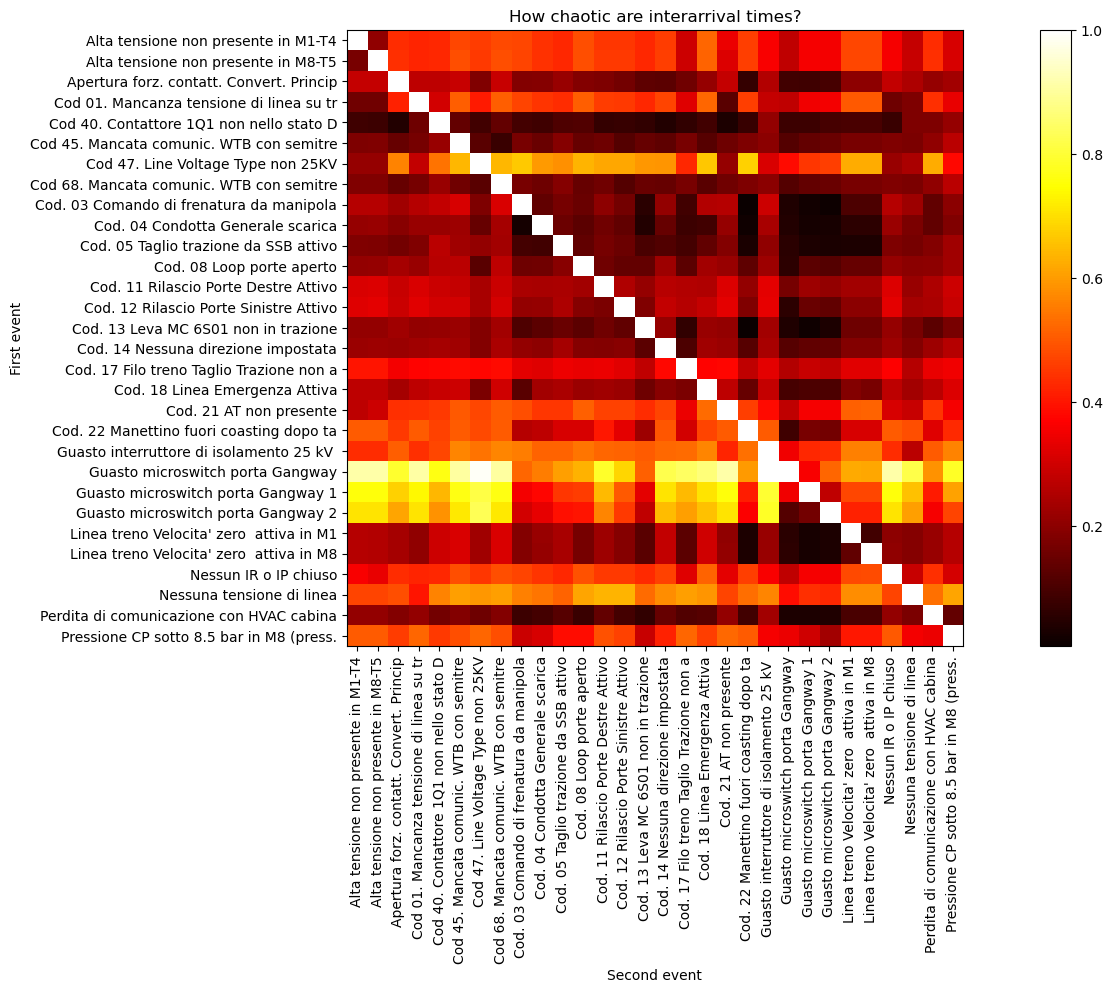

In [284]:
# let's take the standard deviations
interarrival_matrix = interarrival_tensor[:, :, 1]

interarrival_matrix = (interarrival_matrix - interarrival_matrix.min()) \
    / (interarrival_matrix - interarrival_matrix.min()).max()

interarrival_matrix.fill_diagonal_(interarrival_matrix.max())

row_labels = col_labels = [label[:40] for label in list(sig_pair_dict.keys())]

# Convert PyTorch tensor to NumPy array
np_array = interarrival_matrix.numpy()

# Plotting the heatmap
plt.figure(figsize=(20, 8))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How chaotic are interarrival times? ')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()

In [291]:
# let's take the 85% percentile of each distribution
dimension = 4

interarrival_matrix = interarrival_tensor[:, :, 3]


# min max scaling:
interarrival_matrix = (interarrival_matrix - interarrival_matrix.min()) \
    / (interarrival_matrix - interarrival_matrix.min()).max()

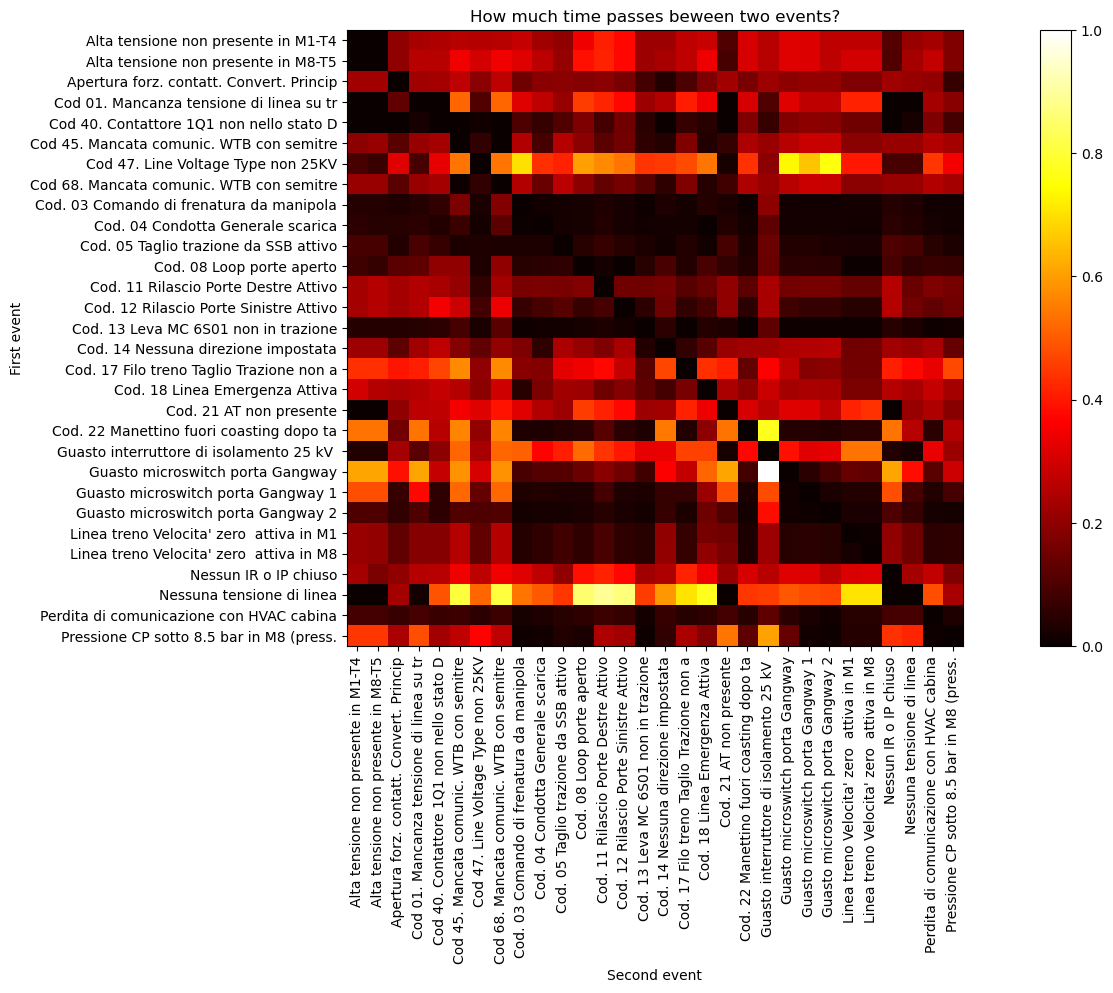

In [297]:
# Example row and column labels (replace with your own labels)
row_labels = col_labels = [label[:40] for label in list(sig_pair_dict.keys())]

# Convert PyTorch tensor to NumPy array
np_array = interarrival_matrix.numpy()

# Plotting the heatmap
plt.figure(figsize=(20, 8))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How much time passes beween two events?')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()

# 2. Differentiating between Events and Anomalies:
_________

TLDR: Looking only at interarrival times between events and anomalies, assuming there is causallity between a pair of those, we can fit our emprical data to an exponential or a multimodal distribution to create very simple pair-wise models from which we can sample events.

In [652]:
main_df = pd.read_csv('dataset.csv')
main_df = main_df.dropna(subset=['Descrizione'])  # clean
main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])
main_df = main_df.sort_values('Timestamp')

# avoid bulks of signals
# (take only the first from a continguous group of signals)
no_bulk_df = main_df.loc[main_df['Descrizione'] != \
                              main_df['Descrizione'].shift(1)].copy()

no_bulk_df = no_bulk_df.drop_duplicates(subset=['Descrizione', 'Timestamp'], keep='first')

# Grouping by 'Category'
grouped = no_bulk_df.groupby('Descrizione')

# Creating a dictionary of DataFrames
dfs = {category: group for category, group in grouped}

In [655]:
# well keep only events with a minimum number of occorrences
analysis_treshold = 100
analyzed_dss = {}

for sig, df in dfs.items():
    if len(df) >= analysis_treshold:
        analyzed_dss[sig] = df

# we differentiate between events and anomalies
anomalies = {}
total_labels = list(analyzed_dss.keys())
for label in total_labels:
    if 'guasto' in label or \
        'abbassamento' in label or \
        'ancanza' in label or \
        'non presente' in label or \
        'fuori servizio' in label or \
        'Mancata ' in label or \
        'mergenza ' in label or \
        'Guasto ' in label or \
        'insufficiente ' in label or \
        'Perdita' in label:
        anomalies[label] = analyzed_dss[label]
        del analyzed_dss[label]
generic_events = analyzed_dss

In [656]:
print(f'total categories: {len(total_labels)}, from which {len(anomalies)} anomalies and {len(generic_events)} events')

total categories: 24, from which 8 anomalies and 16 events


In [657]:
# We now study time correlations between anomalies and events (and between events and anomalies).
event_causes_anomaly_dict = defaultdict(dict)
anomaly_causes_event_dict = defaultdict(dict)

for event_description in tqdm(generic_events):
    for anomaly_description in anomalies:

        curr_df = main_df.loc[
            (main_df['Descrizione'] == event_description) |
            (main_df['Descrizione'] == anomaly_description)].copy()

        curr_df = curr_df.loc[curr_df['Descrizione'] != \
                              curr_df['Descrizione'].shift(1)].copy()

        curr_df['custom_intertime'] = curr_df['Timestamp'].diff()
        curr_df['custom_intertime'].bfill(inplace=True)
        curr_df['custom_intertime'] = curr_df['custom_intertime'].apply(
                                                lambda x: \
                                                x.total_seconds() * 10**6 \
                                                + x.microseconds)  # don't erase microsecs
        curr_df['custom_intertime'] = curr_df['custom_intertime'].apply(
            lambda x: x / 10**6)  # now we can go to (fractional) secs

        event_causes_anomaly_dict[event_description][anomaly_description] = \
            curr_df.loc[curr_df['Descrizione'] == event_description].copy()
        anomaly_causes_event_dict[anomaly_description][event_description] = \
            curr_df.loc[curr_df['Descrizione'] == anomaly_description].copy()

  0%|          | 0/16 [00:00<?, ?it/s]

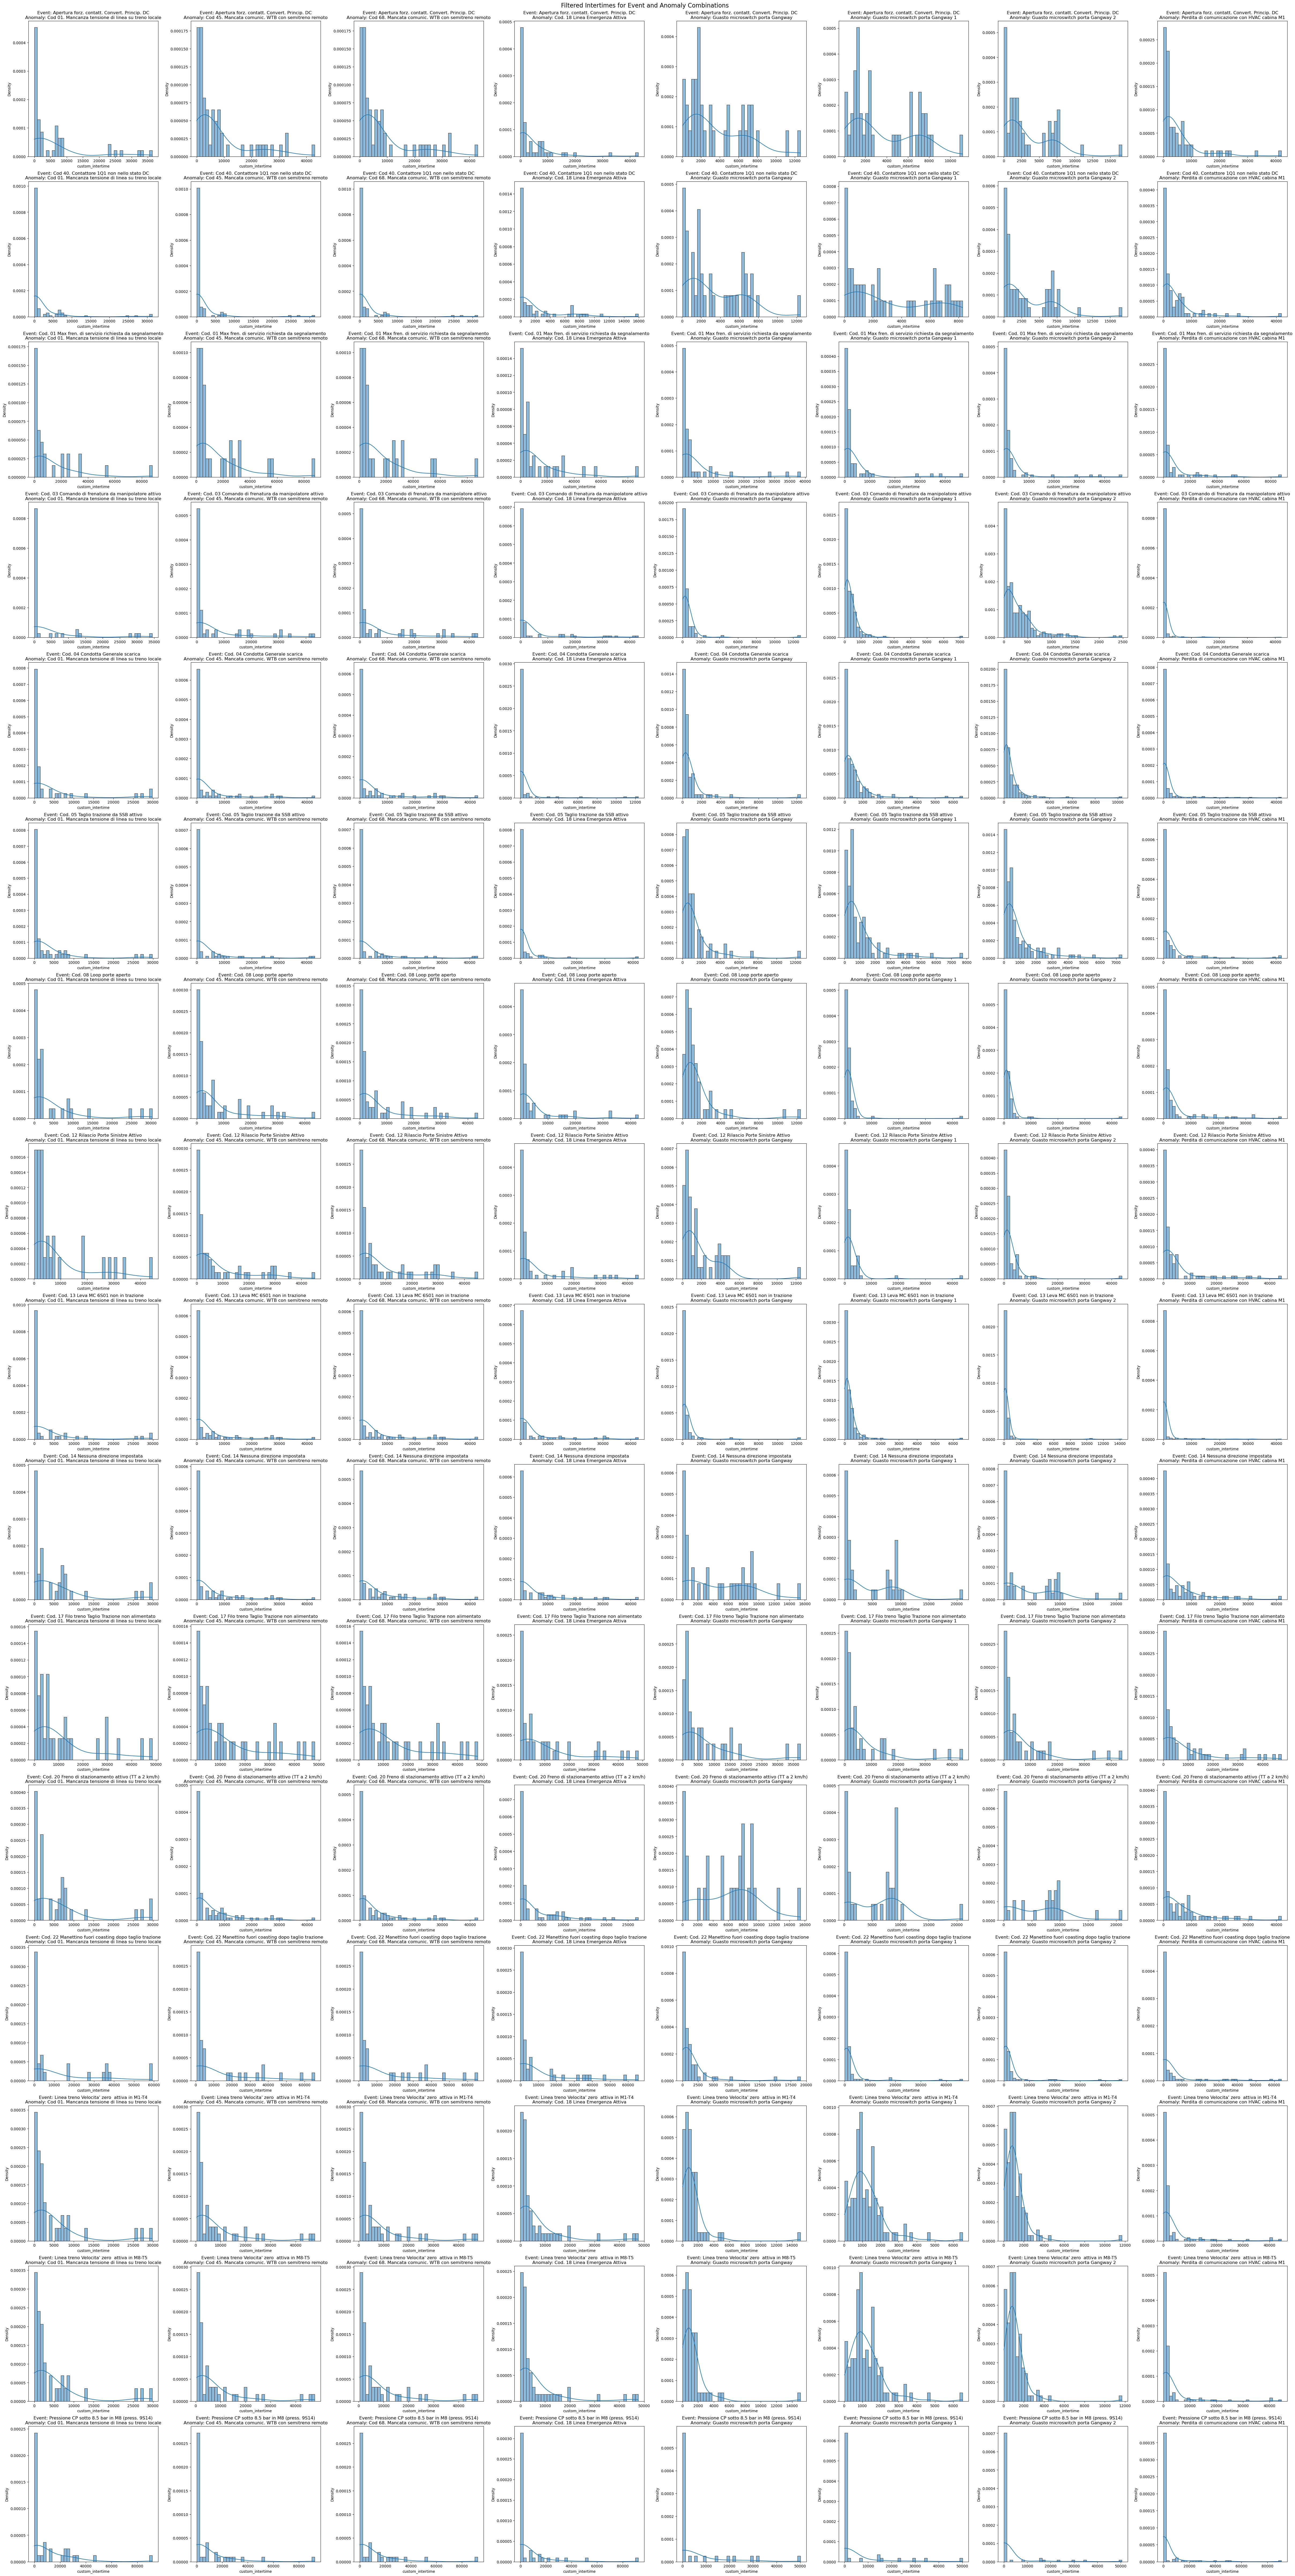

In [660]:
# Create a grid of subplots
nrows = len(event_causes_anomaly_dict)
ncols = len(anomaly_causes_event_dict)
fig, axes = plt.subplots(nrows=nrows,
                         ncols=ncols,
                         figsize=(ncols * 6, nrows * 6),
                         constrained_layout=True)


# Plotting the data
for i, event_description in enumerate(event_causes_anomaly_dict):
    for j, anomaly_description in enumerate(anomaly_causes_event_dict):
        ax = axes[i, j] if nrows > 1 and ncols > 1 else axes[max(i, j)]

        if anomaly_description in event_causes_anomaly_dict[event_description]:
            intertimes = event_causes_anomaly_dict[event_description][anomaly_description]['custom_intertime']

            sns.histplot(intertimes, bins=40, kde=True, stat="density", ax=ax)
            ax.set_title(f'Event: {event_description}\nAnomaly: {anomaly_description}')
        else:
            # If no data is available for the combination, show a blank plot
            ax.axis('off')
            ax.set_title(f'Event: {event_description}\nAnomaly: {anomaly_description} (No Data)')

# Set main title and show plot
fig.suptitle('Filtered Intertimes for Event and Anomaly Combinations', fontsize=16)
plt.show()

In [658]:
z_score_threshold = 1

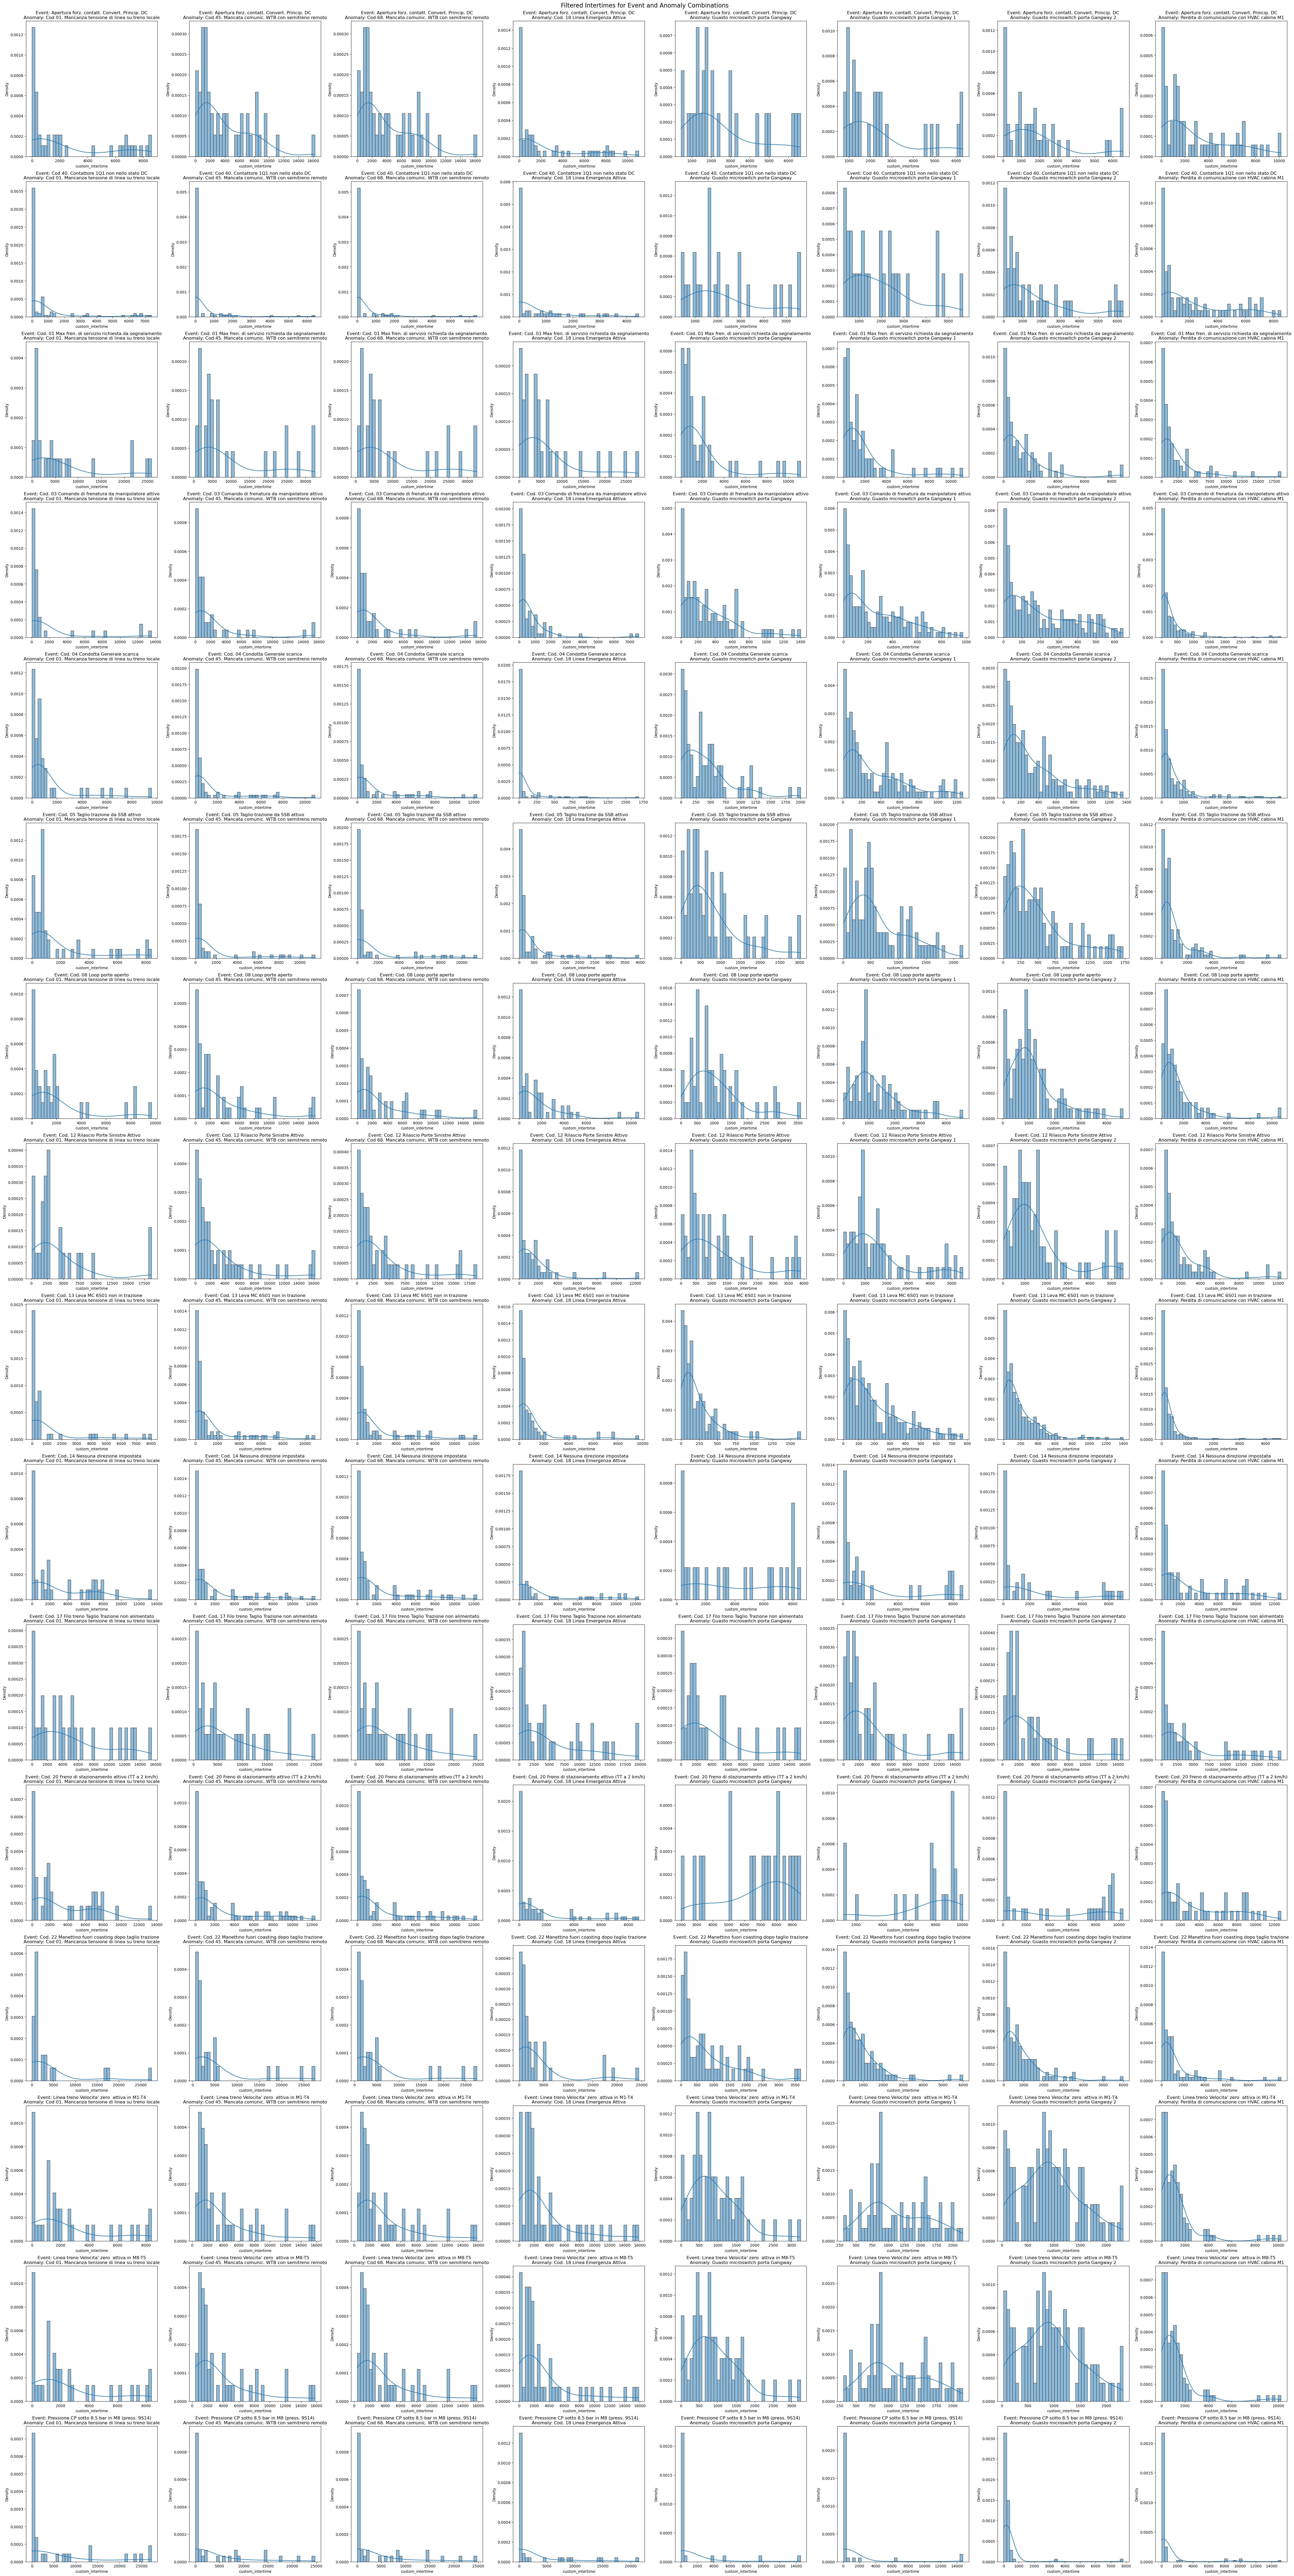

In [659]:
# Create a grid of subplots
nrows = len(event_causes_anomaly_dict)
ncols = len(anomaly_causes_event_dict)
fig, axes = plt.subplots(nrows=nrows,
                         ncols=ncols,
                         figsize=(ncols * 6, nrows * 6),
                         constrained_layout=True)


# Plotting the data
for i, event_description in enumerate(event_causes_anomaly_dict):
    for j, anomaly_description in enumerate(anomaly_causes_event_dict):
        ax = axes[i, j] if nrows > 1 and ncols > 1 else axes[max(i, j)]

        if anomaly_description in event_causes_anomaly_dict[event_description]:
            intertimes = event_causes_anomaly_dict[event_description][anomaly_description]['custom_intertime']
            z_scores = (intertimes - intertimes.mean()) / intertimes.std()
            filtered_intertimes = intertimes[abs(z_scores) <= z_score_threshold]

            sns.histplot(filtered_intertimes, bins=40, kde=True, stat="density", ax=ax)
            ax.set_title(f'Event: {event_description}\nAnomaly: {anomaly_description}')
        else:
            # If no data is available for the combination, show a blank plot
            ax.axis('off')
            ax.set_title(f'Event: {event_description}\nAnomaly: {anomaly_description} (No Data)')

# Set main title and show plot
fig.suptitle('Filtered Intertimes for Event and Anomaly Combinations', fontsize=16)
plt.show()

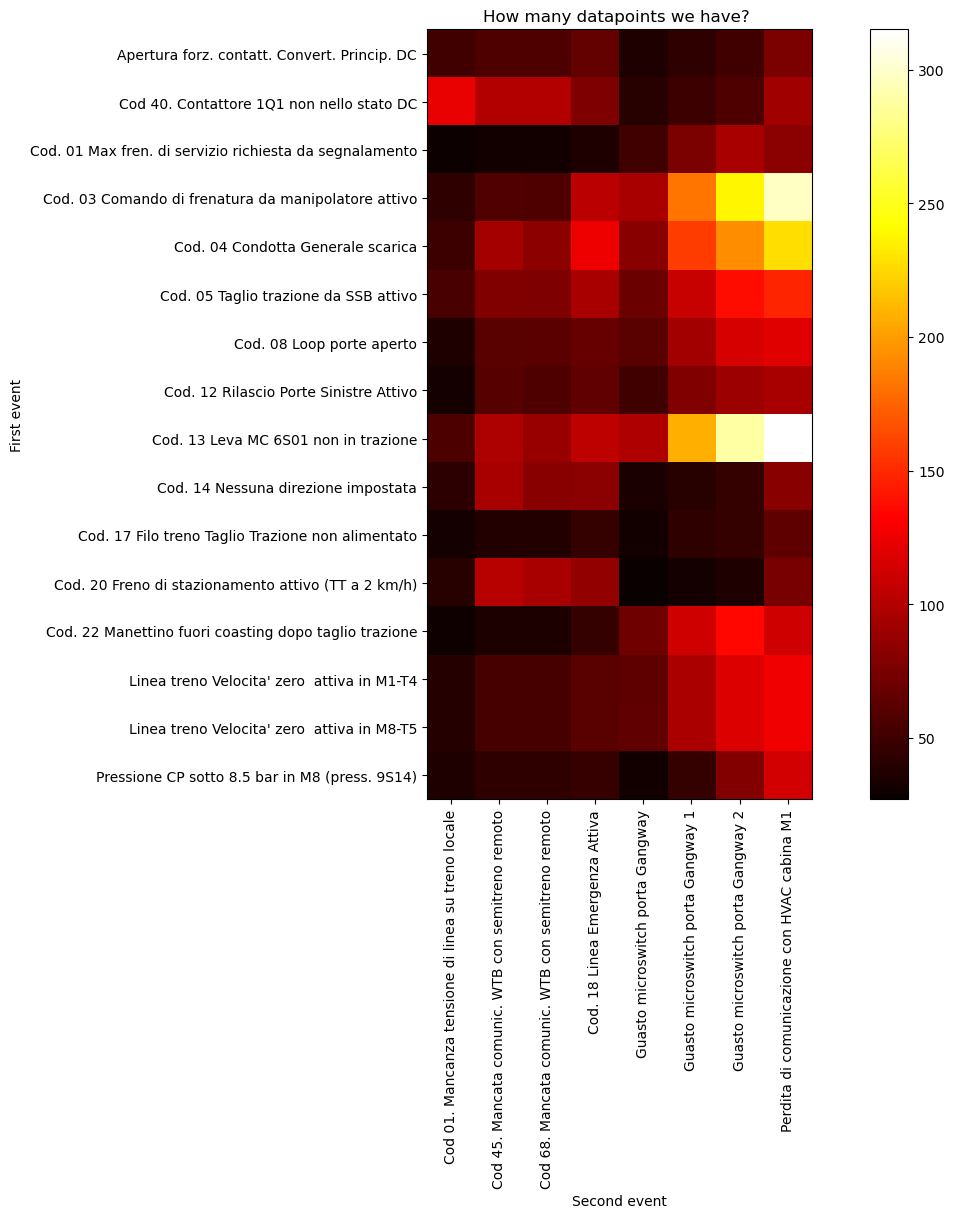

In [661]:
row_labels = list(event_causes_anomaly_dict.keys())
col_labels = list(anomaly_causes_event_dict.keys())

# Specify the size of the tensor (example: 3x4 tensor)
tensor_size = (
    len(event_causes_anomaly_dict),
    len(anomaly_causes_event_dict))

counting = torch.zeros(tensor_size)


for outer_idx, outer_sigkey in enumerate(event_causes_anomaly_dict):
    for inner_idx, inner_sigkey in enumerate(anomaly_causes_event_dict):

        counting[outer_idx][inner_idx] = \
            len(event_causes_anomaly_dict[outer_sigkey][inner_sigkey])

# Convert PyTorch tensor to NumPy array
np_array = counting.numpy()

# Plotting the heatmap
plt.figure(figsize=(15, 10))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How many datapoints we have? ')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()

## Resuming:

In [662]:
event_anom_stats = defaultdict(dict)
anom_event_stats = defaultdict(dict)

for event_description in tqdm(event_causes_anomaly_dict):
    for anomaly_description in anomaly_causes_event_dict:

        pivot_event = event_description
        pivot_df = event_causes_anomaly_dict[event_description][anomaly_description].copy()
        event_anom_stats[event_description][anomaly_description] = torch.Tensor([
            round(pivot_df['custom_intertime'].mean(), 2),
            round(pivot_df['custom_intertime'].std(), 2),
            round(pivot_df['custom_intertime'].quantile(0.5), 2),
            round(pivot_df['custom_intertime'].quantile(0.75), 2),
            round(pivot_df['custom_intertime'].quantile(0.85), 2),
            round(pivot_df['custom_intertime'].quantile(0.9), 2),
            round(pivot_df['custom_intertime'].quantile(0.95), 2)])

        pivot_event = anomaly_description
        pivot_df = anomaly_causes_event_dict[anomaly_description][event_description].copy()
        anom_event_stats[anomaly_description][event_description] = torch.Tensor([
            round(pivot_df['custom_intertime'].mean(), 2),  # dimension 0
            round(pivot_df['custom_intertime'].std(), 2),   # dim 1
            round(pivot_df['custom_intertime'].quantile(0.5), 2),  # dim 2
            round(pivot_df['custom_intertime'].quantile(0.75), 2),  # dim 3
            round(pivot_df['custom_intertime'].quantile(0.85), 2),  # dim 4
            round(pivot_df['custom_intertime'].quantile(0.9), 2),   # dim 5
            round(pivot_df['custom_intertime'].quantile(0.95), 2)])  # dim 6

  0%|          | 0/16 [00:00<?, ?it/s]

### Event -> Anomaly:

In [663]:
# Specify the size of the tensor (example: 3x4 tensor)
tensor_size = (
    len(event_causes_anomaly_dict),
    len(anomaly_causes_event_dict),
    7)

interarrival_tensor = torch.zeros(tensor_size)


for outer_idx, outer_sigkey in enumerate(event_causes_anomaly_dict):
    for inner_idx, inner_sigkey in enumerate(anomaly_causes_event_dict):

        interarrival_tensor[outer_idx][inner_idx] = \
            event_anom_stats[outer_sigkey][inner_sigkey]

In [664]:
interarrival_tensor.shape

torch.Size([16, 8, 7])

#### Variance:

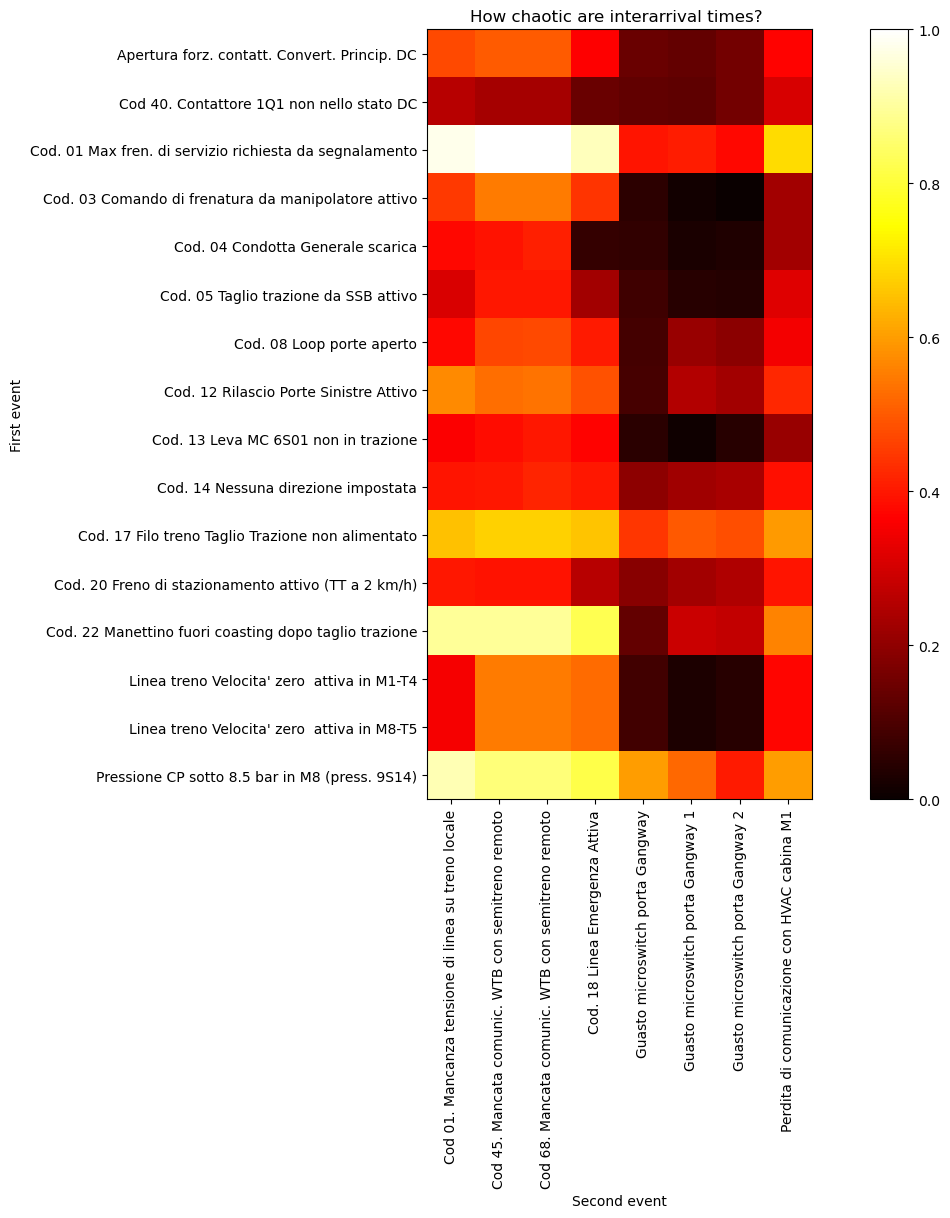

In [665]:
# let's take the standard deviations
interarrival_matrix = interarrival_tensor[:, :, 1]

interarrival_matrix = (interarrival_matrix - interarrival_matrix.min()) \
    / (interarrival_matrix - interarrival_matrix.min()).max()


row_labels = list(event_causes_anomaly_dict.keys())
col_labels = list(anomaly_causes_event_dict.keys())

# Convert PyTorch tensor to NumPy array
np_array = interarrival_matrix.numpy()

# Plotting the heatmap
plt.figure(figsize=(15, 10))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How chaotic are interarrival times? ')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()

#### Time:

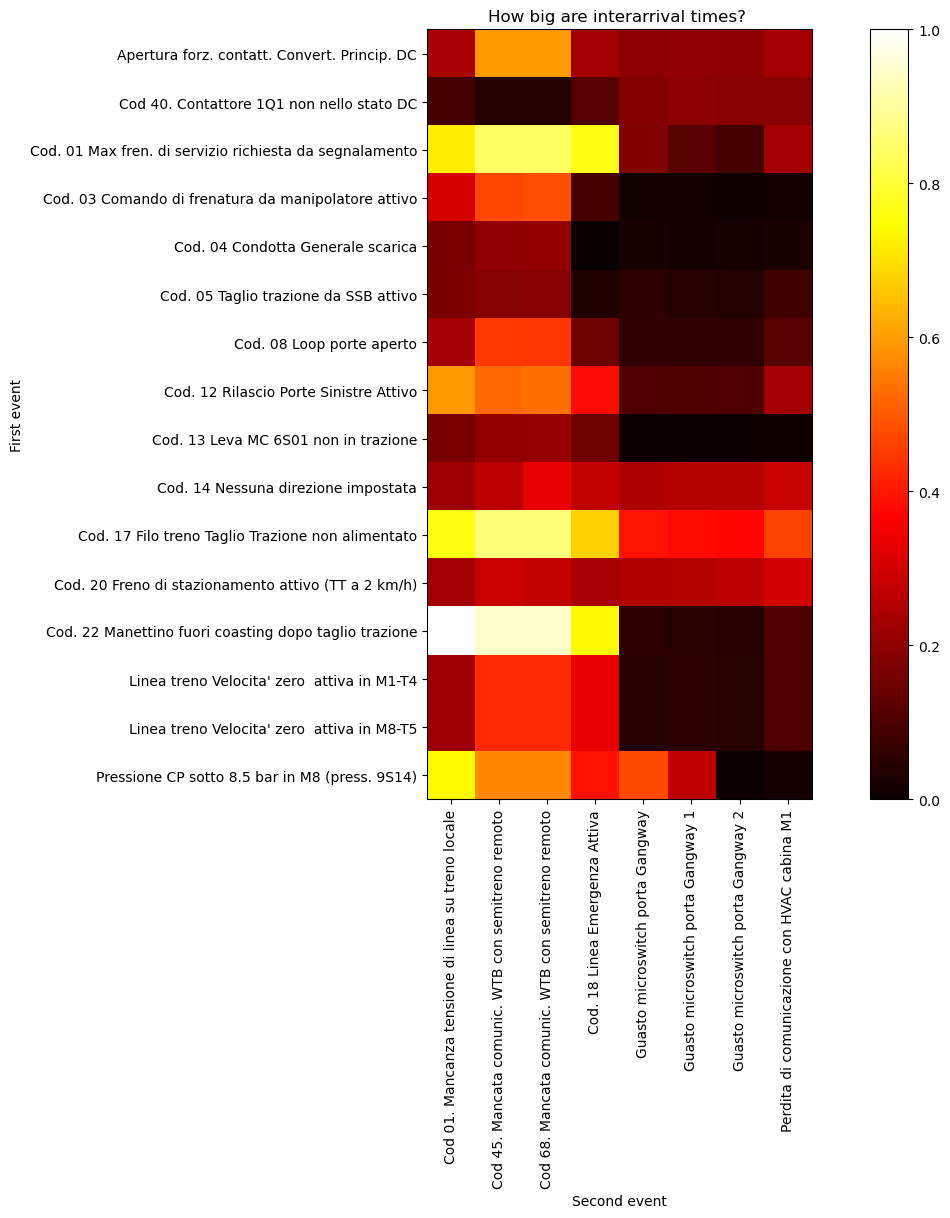

In [666]:
# let's take the 0.85 percentile
interarrival_matrix = interarrival_tensor[:, :, 4]

interarrival_matrix = (interarrival_matrix - interarrival_matrix.min()) \
    / (interarrival_matrix - interarrival_matrix.min()).max()


row_labels = list(event_causes_anomaly_dict.keys())
col_labels = list(anomaly_causes_event_dict.keys())

# Convert PyTorch tensor to NumPy array
np_array = interarrival_matrix.numpy()

# Plotting the heatmap
plt.figure(figsize=(15, 10))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How big are interarrival times? ')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()

### Anomaly -> Event:

In [667]:
# Specify the size of the tensor (example: 3x4 tensor)
tensor_size = (
    len(anomaly_causes_event_dict),
    len(event_causes_anomaly_dict),
    7)

interarrival_tensor = torch.zeros(tensor_size)


for outer_idx, outer_sigkey in enumerate(anomaly_causes_event_dict):
    for inner_idx, inner_sigkey in enumerate(event_causes_anomaly_dict):

        interarrival_tensor[outer_idx][inner_idx] = \
            anom_event_stats[outer_sigkey][inner_sigkey]

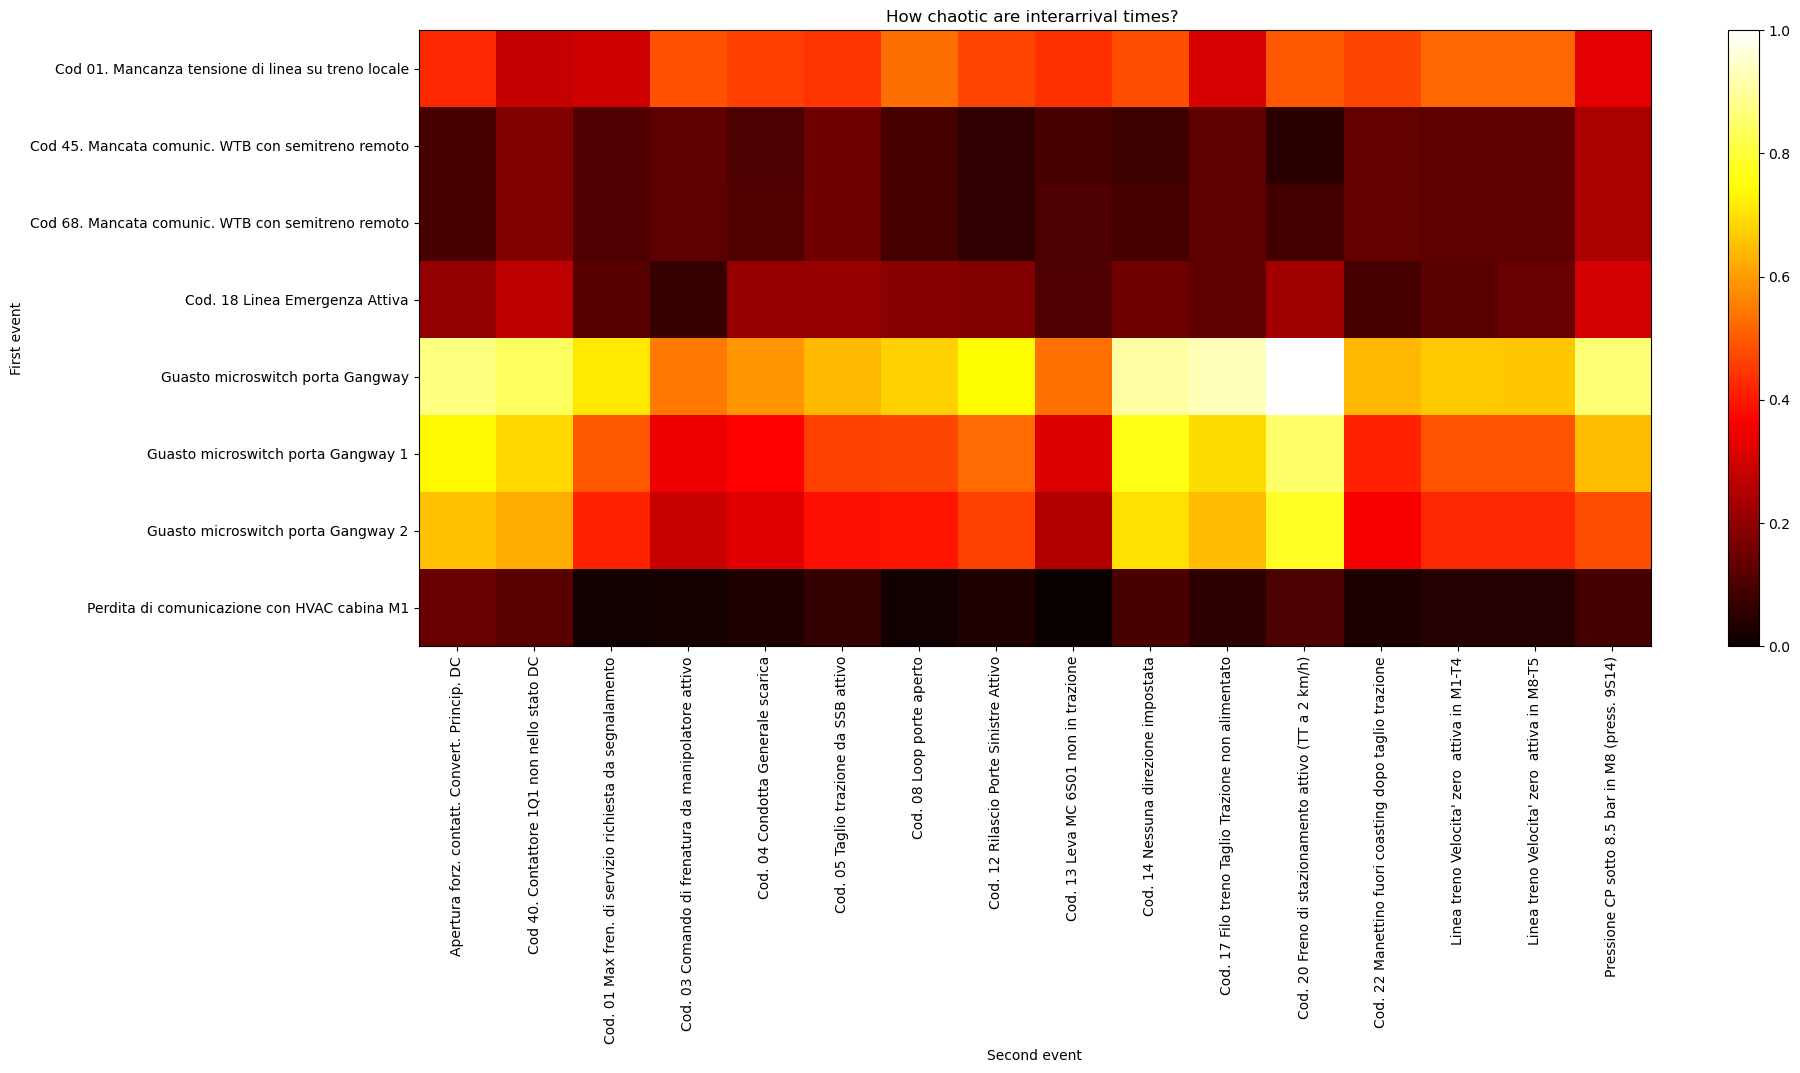

In [668]:
# let's take the standard deviations
interarrival_matrix = interarrival_tensor[:, :, 1]

interarrival_matrix = (interarrival_matrix - interarrival_matrix.min()) \
    / (interarrival_matrix - interarrival_matrix.min()).max()


row_labels = list(anomaly_causes_event_dict.keys())
col_labels = list(event_causes_anomaly_dict.keys())

# Convert PyTorch tensor to NumPy array
np_array = interarrival_matrix.numpy()

# Plotting the heatmap
plt.figure(figsize=(20, 8))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How chaotic are interarrival times? ')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()

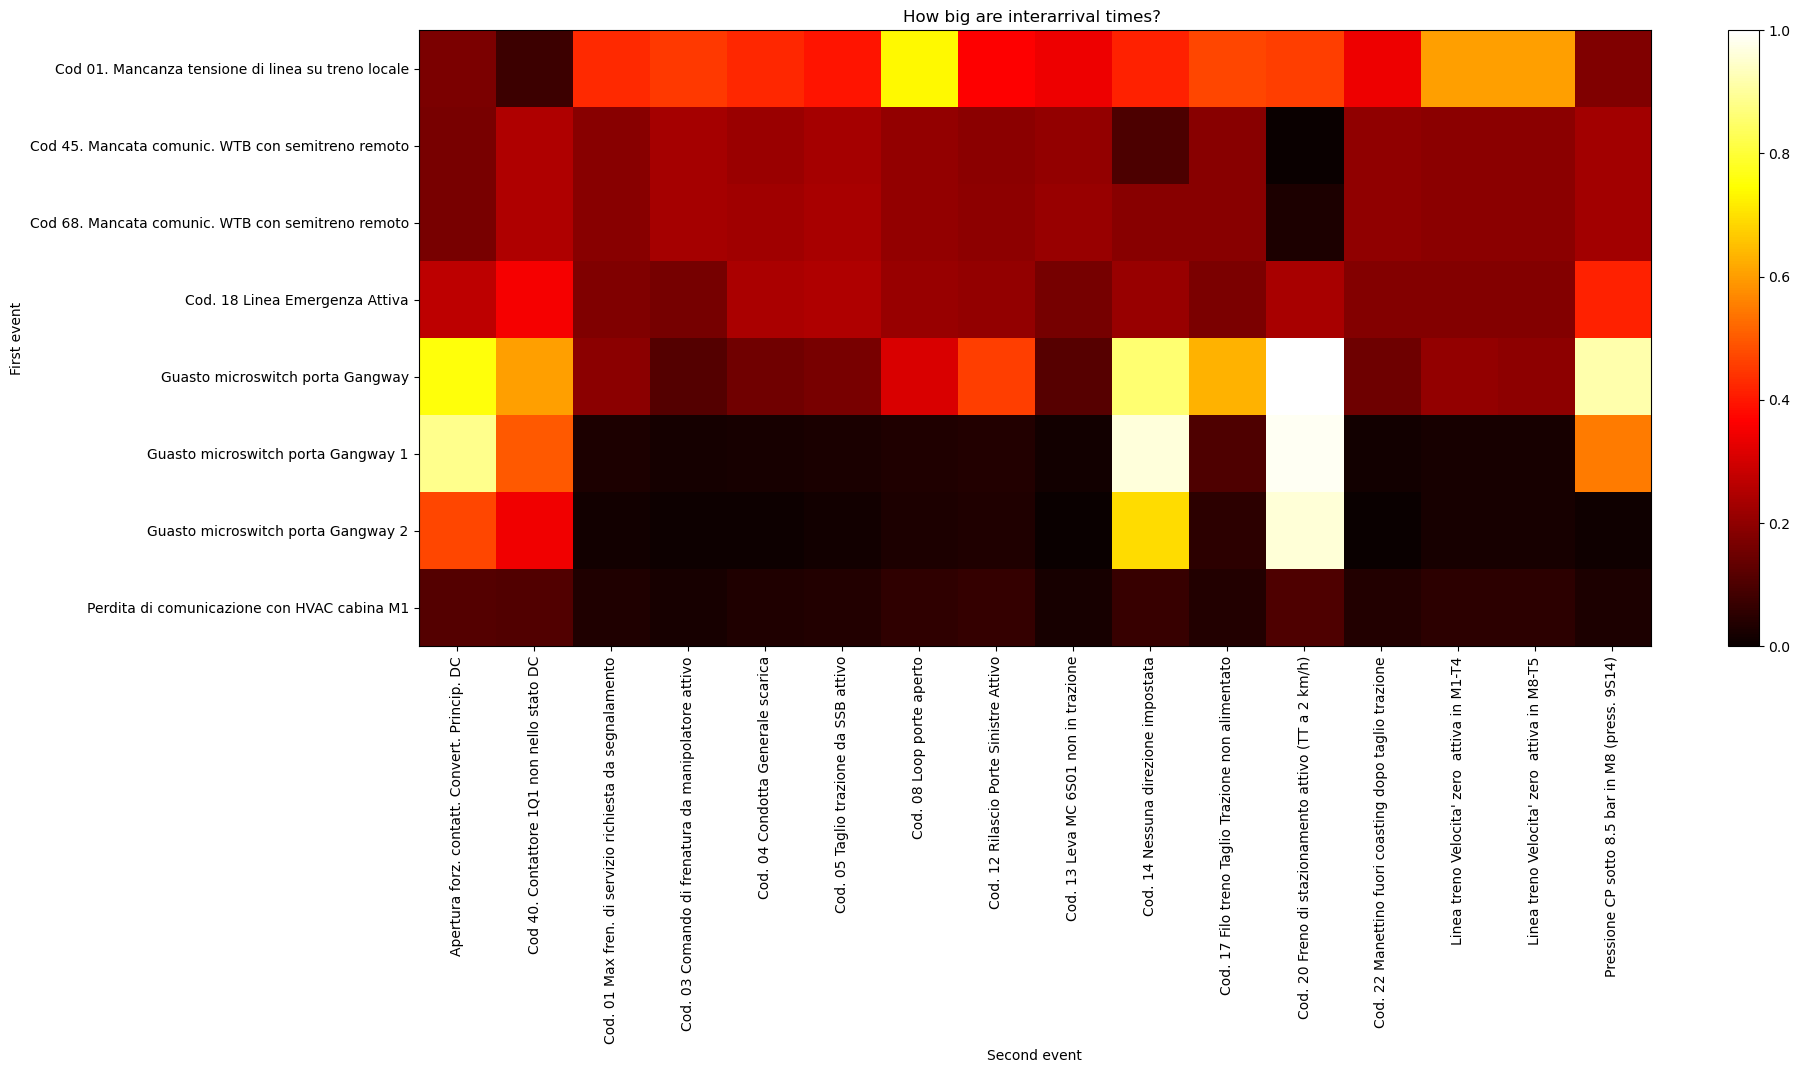

In [669]:
# let's take the 0.85 percentile
interarrival_matrix = interarrival_tensor[:, :, 4]

interarrival_matrix = (interarrival_matrix - interarrival_matrix.min()) \
    / (interarrival_matrix - interarrival_matrix.min()).max()


row_labels = list(anomaly_causes_event_dict.keys())
col_labels = list(event_causes_anomaly_dict.keys())

# Convert PyTorch tensor to NumPy array
np_array = interarrival_matrix.numpy()

# Plotting the heatmap
plt.figure(figsize=(20, 8))
plt.imshow(np_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show scale

# Add labels to the plot
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=90)
plt.yticks(np.arange(len(row_labels)), row_labels)

plt.title('How big are interarrival times? ')
plt.xlabel('Second event')
plt.ylabel('First event')
plt.show()